In [1]:
import pandas as pd
import datetime
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from typing import List, Tuple

import missingno as msno

from catboost import CatBoostClassifier

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')


pd.options.display.max_rows=100
pd.options.display.max_columns=400

In [2]:
train = pd.read_csv('assignment_train.csv')
test = pd.read_csv('assignment_test.csv')

### Обзор данных

In [3]:
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [4]:
test.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3062000,0,1643492,41.0,W,9500,321.0,150.0,visa,226.0,debit,126.0,87.0,NaN,NaN,aol.com,NaN,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,50.0,2.0,104.0,104.0,0.0,317.0,0.0,NaN,NaN,NaN,NaN,317.0,NaN,NaN,NaN,NaN,317.0,NaN,NaN,NaN,M1,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,43.0,22.0,4.0,40.0,20.0,0.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,194.0,2168.0,1139.0,194.0,1965.5,991.0,0.0,202.5,148.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,20.0,0.0,0.0,0.0,4.0,44.0,0.0,20.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,194.0,2172.0,991.0,194.0,2172.0,0.0,991.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3062001,1,1643513,161.0,W,6668,390.0,150.0,mastercard,224.0,debit,325.0,87.0,55.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,F,M0,T,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 150.3+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 225.4+ MB


В тестовых данных признаков, в которых присутствуют пропуски, гораздо больше.

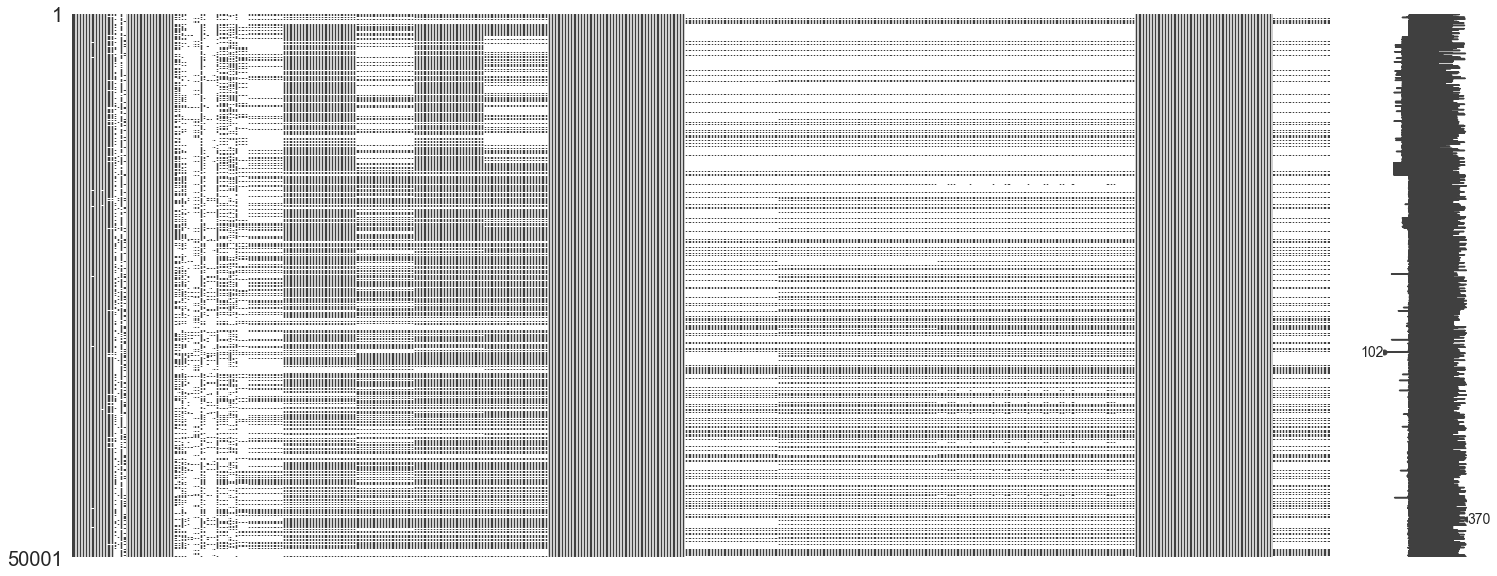

In [7]:
msno.matrix(train);

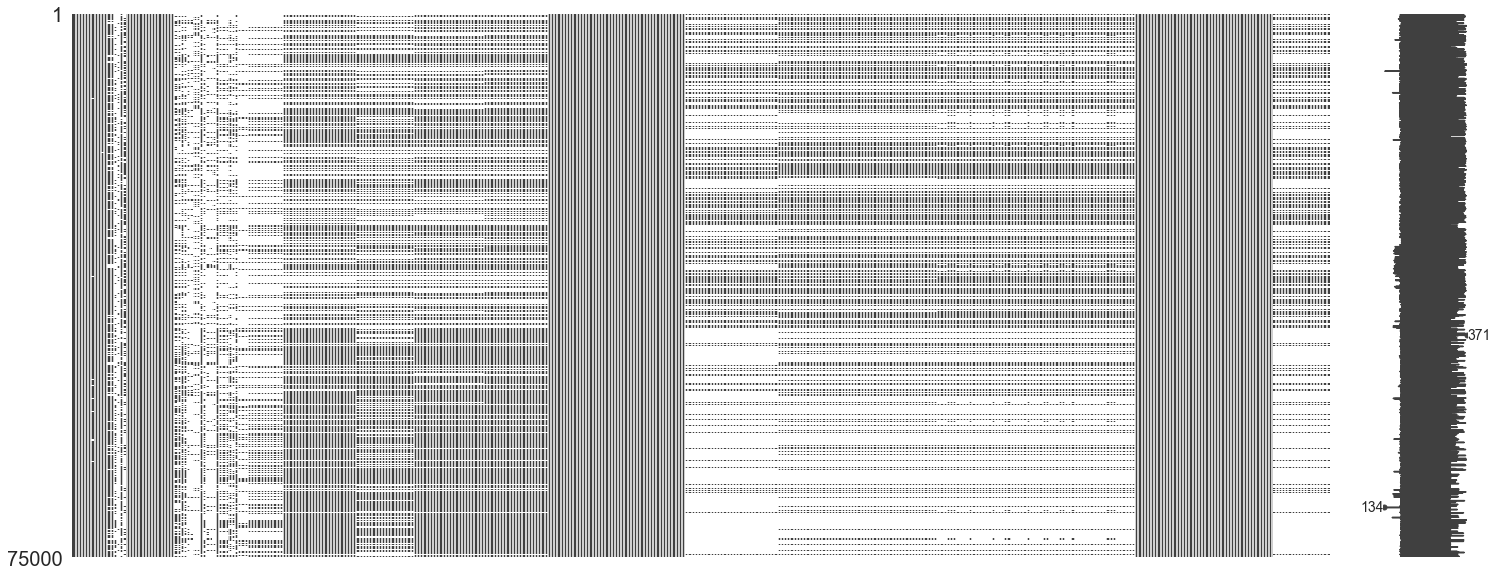

In [8]:
msno.matrix(test);

Пропуски в трейне и тесте распределены по-разному, скорее всего, признаки с большим количеством пропуском - кандидаты на удаление.

In [9]:
features_with_gaps = train.columns[train.isnull().sum() / len(train) * 100 > 50].tolist()
len(features_with_gaps)

192

In [10]:
train = train.drop(columns=features_with_gaps)
test = test.drop(columns=features_with_gaps)

### Построение списков признаков

#### Количественные признаки

In [11]:
quantitative_features = train.select_dtypes('int64').drop(columns=['TransactionID', 'isFraud']).columns.tolist()
quantitative_features

['TransactionDT', 'card1']

In [12]:
round((
    len(train[quantitative_features]) - train[quantitative_features].count()) / 
    len(train[quantitative_features]) * 100, 2).sort_values(ascending=False)

card1            0.0
TransactionDT    0.0
dtype: float64

In [13]:
train[quantitative_features].nunique().sort_values()

card1             5446
TransactionDT    48346
dtype: int64

Количественные признаки не имеют пропусков. Но TransactionDT - это время транзакции, удалим этом признак из модели.

In [14]:
quantitative_features = ['card1']

#### Категориальные признаки

In [15]:
cat_features = train.select_dtypes('object').columns.tolist()
cat_features

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M6']

In [16]:
round((len(train[cat_features]) - train[cat_features].count()) / len(train[cat_features]) * 100, 2).sort_values(ascending=False)

M6               37.34
P_emaildomain    17.97
card6             0.01
card4             0.01
ProductCD         0.00
dtype: float64

In [17]:
train[cat_features].nunique().sort_values()

M6                2
card4             4
card6             4
ProductCD         5
P_emaildomain    59
dtype: int64

Для пропущенных значений создадим отдельную категорию.

In [18]:
train['M6'].value_counts(), train['M6'].isnull().sum()

(F    17030
 T    14300
 Name: M6, dtype: int64,
 18671)

In [19]:
train['M6'].fillna(-1, inplace=True)
train.loc[train['M6'] == 'T', 'M6'] = 1
train.loc[train['M6'] == 'F', 'M6'] = 0

In [20]:
test['M6'].fillna(-1, inplace=True)
test.loc[test['M6'] == 'T', 'M6'] = 1
test.loc[test['M6'] == 'F', 'M6'] = 0

In [21]:
train['P_emaildomain'].value_counts(), train['P_emaildomain'].isnull().sum()

(gmail.com           17910
 yahoo.com            8360
 hotmail.com          3728
 anonymous.com        3466
 aol.com              2443
 comcast.net           849
 icloud.com            468
 msn.com               387
 outlook.com           360
 att.net               326
 sbcglobal.net         307
 verizon.net           288
 live.com              247
 ymail.com             184
 bellsouth.net         182
 cox.net               157
 charter.net           141
 me.com                134
 yahoo.com.mx          126
 optonline.net         104
 live.com.mx            71
 rocketmail.com         59
 earthlink.net          55
 gmail                  41
 mail.com               38
 roadrunner.com         38
 mac.com                37
 juno.com               33
 embarqmail.com         33
 windstream.net         32
 twc.com                30
 web.de                 29
 frontier.com           28
 netzero.com            24
 frontiernet.net        24
 cfl.rr.com             24
 prodigy.net.mx         23
 

Сократим количество категорий у этого признака, объединив в одну те, что содержат меньше 3000 вхождений.

In [22]:
train.loc[~
    ((train['P_emaildomain'] == 'gmail.com') | 
    (train['P_emaildomain'] == 'yahoo.com') | 
    (train['P_emaildomain'] == 'hotmail.com') | 
    (train['P_emaildomain'] == 'anonymous.com')), 'P_emaildomain'] = 'other'

In [23]:
test.loc[~
    ((test['P_emaildomain'] == 'gmail.com') | 
    (test['P_emaildomain'] == 'yahoo.com') | 
    (test['P_emaildomain'] == 'hotmail.com') | 
    (test['P_emaildomain'] == 'anonymous.com')), 'P_emaildomain'] = 'other'

In [24]:
train['P_emaildomain'].fillna('missing', inplace=True)
test['P_emaildomain'].fillna('missing', inplace=True)

In [25]:
train['P_emaildomain'].value_counts()

gmail.com        17910
other            16537
yahoo.com         8360
hotmail.com       3728
anonymous.com     3466
Name: P_emaildomain, dtype: int64

#### Вещественные признаки

In [26]:
float_features = train.select_dtypes('float64').columns.tolist()
len(float_features)

193

Признаков, которые принимают вещественные значения, очень много, посмотрим на них внимательнее, возможно, не все признаки вещественные.

In [27]:
train_nunique = train[float_features].apply(lambda x: x.nunique(dropna=False))
train_nunique.shape

(193,)

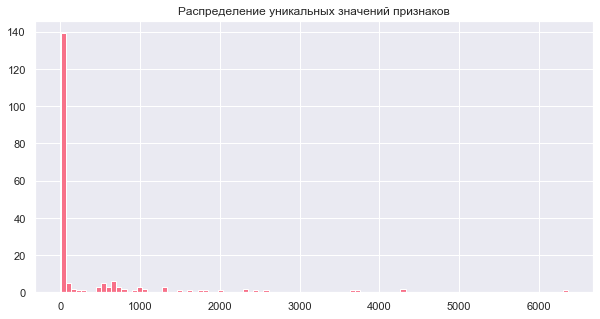

In [28]:
plt.title("Распределение уникальных значений признаков");
train_nunique.hist(bins=100, figsize=(10, 5));

In [29]:
all_features = set(train_nunique.index.tolist())
len(all_features)

193

#### Константные признаки

In [30]:
const_features = set(train_nunique[train_nunique == 1].index.tolist())
const_features

{'V107'}

In [31]:
train.loc[:5, 'V107'], test.loc[:5, 'V107']

(0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
 5    1.0
 Name: V107, dtype: float64,
 0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
 5    1.0
 Name: V107, dtype: float64)

In [32]:
train['V107'].isnull().sum()

0

Константный признак не будем использовать для модели.

#### Вещественные признаки

In [33]:
numeric_features = (train[float_features].fillna(0).astype(int).sum() - train[float_features].fillna(0).sum()).abs()
numeric_features = set(numeric_features[numeric_features > 0].index.tolist())
len(numeric_features)

29

In [34]:
other = all_features - (numeric_features | const_features)
len(other)

163

#### Бинарные

In [35]:
binary_features = set(train[float_features].loc[:, other].columns[(
                      (train[float_features].loc[:, other].max() == 1) & \
                      (train[float_features].loc[:, other].min() == 0) & \
                      (train[float_features].loc[:, other].isnull().sum() == 0))])
len(binary_features)

0

Бинарных признаков нет.

In [36]:
numeric_features = numeric_features | other

In [37]:
other = other - numeric_features
len(other)

0

Таким образом мы выделили четыре типа данных в наших выборках: целочисленные, категориальные, вещественые и один константный.

In [38]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Columns: 202 entries, TransactionID to V321
dtypes: float64(193), int64(5), object(4)
memory usage: 77.1+ MB


In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Columns: 202 entries, TransactionID to V321
dtypes: float64(193), int64(5), object(4)
memory usage: 115.6+ MB


Если будете решать ДЗ на отдельном датасете (не датасет из соревнования) - то использовать датасет из ДЗ2, IEEE-Fraud-Detection Challenge.

### Задание 0: 
выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

In [41]:
def fit_catboost(x_train, y_train, model_params, categorical, *args):
    """
    Обучение модели CatBoostClassifier.

    Parameters
    ----------
    x_train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для валидации модели.

    model_params: dict
        Словарь со значением гиперпараметров модели.

    categorical: List[str]
        Список с названием категориальных признаков.

    Returns
    -------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    """
    eval_set = [(x_train, y_train)]

    if args == 2:
        eval_set.append((args[0], args[1]))

    model = CatBoostClassifier(**model_params)
    model.fit(
        X=x_train,
        y=y_train,
        eval_set=eval_set,
        cat_features=categorical
    )

    return model

In [42]:
def evaluate_model(model, *args):
    """
    Оценка качества модели.

    Parameters
    ----------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    args: pandas.core.frame.DataFrame
        Пары из обучающей выборки и вектора истинных ответов.
        Опциональные параметры.

    """
    eval_data = [(args[i], args[i+1]) for i in range(0, len(args), 2)]
    if eval_data:
        for sample, target in eval_data:
            y_pred = model.predict_proba(sample)[:, 1]
            score = roc_auc_score(target, y_pred)
            print(f"score = {round(score, 6)}")

In [43]:
def prepare_data(X, categorical, to_drop):
    """
    Преобразование данных для передачи в модель.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков для передачи в модель.

    categorical: List[str]
        Список с названием категориальных признаков.

    drop_features: List[str]
        Список с названием признаков, которые не должны
        участвовать в обучении.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Матрица признаков, подготовленная для передачи в модель.

    """
    X_transformed = X.copy()
    to_drop = set(X.columns) & set(to_drop)

    if to_drop:
        X_transformed = X_transformed.drop(to_drop, axis=1)

    X_transformed[categorical] = X_transformed[categorical].astype(str)
    return X_transformed

In [44]:
to_drop = [
    "TransactionID",
    "TransactionDT",
    "isFraud",
]

In [45]:
categorical = train.select_dtypes(include=["object"]).columns.tolist()

In [46]:
x_train, x_valid = train_test_split(
    train, train_size=0.7, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.7, random_state=27, shuffle=True
)

In [47]:
x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_public_lb = prepare_data(test, categorical=categorical, to_drop=to_drop)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_public_lb.shape))

x_train.shape = 35000 rows, 199 cols
x_valid.shape = 15001 rows, 199 cols
x_test.shape = 75000 rows, 199 cols


In [48]:
cb_params_1000 = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27
}

In [49]:
model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)

0:	test: 0.6515258	best: 0.6515258 (0)	total: 101ms	remaining: 3m 21s
10:	test: 0.7592730	best: 0.7592730 (10)	total: 584ms	remaining: 1m 45s
20:	test: 0.7832676	best: 0.7856442 (18)	total: 1.05s	remaining: 1m 38s
30:	test: 0.7981113	best: 0.7985792 (28)	total: 1.48s	remaining: 1m 34s
40:	test: 0.8018721	best: 0.8031421 (37)	total: 1.93s	remaining: 1m 32s
50:	test: 0.8122854	best: 0.8132879 (48)	total: 2.36s	remaining: 1m 30s
60:	test: 0.8135209	best: 0.8145212 (53)	total: 2.79s	remaining: 1m 28s
70:	test: 0.8187845	best: 0.8194629 (68)	total: 3.23s	remaining: 1m 27s
80:	test: 0.8238431	best: 0.8238431 (80)	total: 3.64s	remaining: 1m 26s
90:	test: 0.8257408	best: 0.8259125 (86)	total: 4.03s	remaining: 1m 24s
100:	test: 0.8353597	best: 0.8353597 (100)	total: 4.45s	remaining: 1m 23s
110:	test: 0.8410125	best: 0.8410125 (110)	total: 4.86s	remaining: 1m 22s
120:	test: 0.8456779	best: 0.8456779 (120)	total: 5.28s	remaining: 1m 22s
130:	test: 0.8490043	best: 0.8490629 (129)	total: 5.7s	remai

1130:	test: 0.8946418	best: 0.8946418 (1130)	total: 47.5s	remaining: 36.5s
1140:	test: 0.8949596	best: 0.8949596 (1140)	total: 47.9s	remaining: 36.1s
1150:	test: 0.8952119	best: 0.8952119 (1150)	total: 48.3s	remaining: 35.6s
1160:	test: 0.8953298	best: 0.8953298 (1160)	total: 48.7s	remaining: 35.2s
1170:	test: 0.8953933	best: 0.8953933 (1170)	total: 49.1s	remaining: 34.8s
1180:	test: 0.8955175	best: 0.8955175 (1180)	total: 49.6s	remaining: 34.4s
1190:	test: 0.8957121	best: 0.8957121 (1190)	total: 50s	remaining: 33.9s
1200:	test: 0.8957354	best: 0.8957354 (1200)	total: 50.3s	remaining: 33.5s
1210:	test: 0.8958638	best: 0.8958638 (1210)	total: 50.7s	remaining: 33.1s
1220:	test: 0.8959927	best: 0.8959927 (1220)	total: 51.1s	remaining: 32.6s
1230:	test: 0.8960038	best: 0.8960038 (1229)	total: 51.5s	remaining: 32.2s
1240:	test: 0.8960292	best: 0.8960298 (1238)	total: 51.9s	remaining: 31.7s
1250:	test: 0.8960739	best: 0.8960743 (1248)	total: 52.2s	remaining: 31.3s
1260:	test: 0.8960872	best:

In [50]:
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_public_lb, test["isFraud"])

score = 0.904306
score = 0.869919
score = 0.865427


In [51]:
# bestTest = 0.9043056882
# bestIteration = 1999

# score = 0.904306
# score = 0.869919
# score = 0.865427

### Задание 1: 
признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

In [52]:
import datetime
from datetime import timedelta, datetime, date

In [53]:
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: timedelta(seconds=x))

In [54]:
test['TransactionDT'] = test['TransactionDT'].apply(lambda x: timedelta(seconds=x))

In [55]:
base_date = datetime.fromisoformat('2017-12-01')
base_date

datetime.datetime(2017, 12, 1, 0, 0)

In [56]:
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: base_date + x)

In [57]:
train['TransactionDT'].head()

0   2017-12-02 00:00:00
1   2017-12-02 00:00:01
2   2017-12-02 00:01:09
3   2017-12-02 00:01:39
4   2017-12-02 00:01:46
Name: TransactionDT, dtype: datetime64[ns]

In [58]:
test['TransactionDT'] = test['TransactionDT'].apply(lambda x: base_date + x)

In [59]:
train['year'] = train['TransactionDT'].dt.year
train['month'] = train['TransactionDT'].dt.month
train['dayofmonth'] = train['TransactionDT'].dt.day
train['quarter'] = train['TransactionDT'].dt.quarter
train['dayofyear'] = train['TransactionDT'].dt.dayofyear
train['weekofyear'] = train['TransactionDT'].dt.weekofyear
train['dayofweek'] = train['TransactionDT'].dt.dayofweek
train['hour'] = train['TransactionDT'].dt.hour

In [60]:
test['year'] = test['TransactionDT'].dt.year
test['month'] = test['TransactionDT'].dt.month
test['dayofmonth'] = test['TransactionDT'].dt.day
test['quarter'] = test['TransactionDT'].dt.quarter
test['dayofyear'] = test['TransactionDT'].dt.dayofyear
test['weekofyear'] = test['TransactionDT'].dt.weekofyear
test['dayofweek'] = test['TransactionDT'].dt.dayofweek
test['hour'] = test['TransactionDT'].dt.hour

In [61]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour
0,2987000,0,2017-12-02 00:00:00,68.5,W,13926,0.0,150.0,discover,142.0,credit,315.0,87.0,other,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,13.0,0.0,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,2017,12,2,4,336,48,5,0
1,2987001,0,2017-12-02 00:00:01,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,12,2,4,336,48,5,0
2,2987002,0,2017-12-02 00:01:09,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,other,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,315.0,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,12,2,4,336,48,5,0
3,2987003,0,2017-12-02 00:01:39,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,94.0,84.0,111.0,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0

In [62]:
x_train, x_valid = train_test_split(
    train, train_size=0.7, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.7, random_state=27, shuffle=True
)

x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_public_lb = prepare_data(test, categorical=categorical, to_drop=to_drop)

model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)

evaluate_model(model, x_train, y_train, x_valid, y_valid, x_public_lb, test["isFraud"])

0:	test: 0.5896372	best: 0.5896372 (0)	total: 52ms	remaining: 1m 43s
10:	test: 0.7697440	best: 0.7731105 (8)	total: 464ms	remaining: 1m 23s
20:	test: 0.7736941	best: 0.7736941 (20)	total: 884ms	remaining: 1m 23s
30:	test: 0.7813129	best: 0.7813129 (30)	total: 1.3s	remaining: 1m 22s
40:	test: 0.7911152	best: 0.7911152 (40)	total: 1.71s	remaining: 1m 21s
50:	test: 0.7935185	best: 0.7935185 (50)	total: 2.13s	remaining: 1m 21s
60:	test: 0.8103943	best: 0.8105053 (58)	total: 2.55s	remaining: 1m 21s
70:	test: 0.8133912	best: 0.8134693 (68)	total: 2.97s	remaining: 1m 20s
80:	test: 0.8164861	best: 0.8164861 (80)	total: 3.38s	remaining: 1m 20s
90:	test: 0.8254083	best: 0.8254083 (90)	total: 3.79s	remaining: 1m 19s
100:	test: 0.8350507	best: 0.8350507 (100)	total: 4.21s	remaining: 1m 19s
110:	test: 0.8399535	best: 0.8401412 (109)	total: 4.66s	remaining: 1m 19s
120:	test: 0.8455593	best: 0.8455668 (119)	total: 5.12s	remaining: 1m 19s
130:	test: 0.8478783	best: 0.8478783 (130)	total: 5.56s	remaini

1130:	test: 0.8958924	best: 0.8958924 (1130)	total: 48.2s	remaining: 37s
1140:	test: 0.8959070	best: 0.8959140 (1134)	total: 48.6s	remaining: 36.6s
1150:	test: 0.8959455	best: 0.8959455 (1150)	total: 49s	remaining: 36.2s
1160:	test: 0.8960156	best: 0.8960156 (1160)	total: 49.5s	remaining: 35.7s
1170:	test: 0.8960281	best: 0.8960286 (1168)	total: 49.8s	remaining: 35.3s
1180:	test: 0.8960727	best: 0.8960727 (1180)	total: 50.2s	remaining: 34.8s
1190:	test: 0.8960801	best: 0.8960801 (1190)	total: 50.6s	remaining: 34.4s
1200:	test: 0.8961079	best: 0.8961079 (1199)	total: 51s	remaining: 33.9s
1210:	test: 0.8961287	best: 0.8961287 (1210)	total: 51.4s	remaining: 33.5s
1220:	test: 0.8961754	best: 0.8961754 (1220)	total: 51.8s	remaining: 33.1s
1230:	test: 0.8962174	best: 0.8962174 (1230)	total: 52.2s	remaining: 32.6s
1240:	test: 0.8962575	best: 0.8962575 (1239)	total: 52.6s	remaining: 32.1s
1250:	test: 0.8963193	best: 0.8963193 (1250)	total: 53s	remaining: 31.7s
1260:	test: 0.8963462	best: 0.896

In [63]:
# Бейзлайн:
# bestTest = 0.9043056882
# bestIteration = 1999

# score = 0.904306
# score = 0.869919
# score = 0.865427

Скор вырос

### Задание 2: 
сгруппировать данные по card1 и посчитать среднюю сумму транзакции. Добавить в качестве признака в набор данных. Посчитать разницу между суммой транзакцией пользователя и средней суммой транзакции по данному типу card1. Построить отношение этих признаков. Повторить процедуру для всех card.

In [64]:
for i, card in enumerate(['card1', 'card2', 'card3', 'card4', 'card5', 'card6']):
    train = train.merge(train.groupby(card)['TransactionAmt'].mean().reset_index().rename(
        columns={'TransactionAmt': f'card{i+1}_mean_amt'}), on=f'card{i+1}')

In [65]:
for i, card in enumerate(['card1', 'card2', 'card3', 'card4', 'card5', 'card6']):
    test = test.merge(test.groupby(card)['TransactionAmt'].mean().reset_index().rename(
        columns={'TransactionAmt': f'card{i+1}_mean_amt'}), on=f'card{i+1}')

In [66]:
for i, card in enumerate(['card1', 'card2', 'card3', 'card4', 'card5', 'card6']):
    train['card_amt_diff'] = train['TransactionAmt'].copy() - train[f'card{i+1}_mean_amt'].copy()
    train['card_amt_div'] = train['TransactionAmt'].copy() / train[f'card{i+1}_mean_amt'].copy()

In [67]:
for i, card in enumerate(['card1', 'card2', 'card3', 'card4', 'card5', 'card6']):
    test['card_amt_diff'] = test['TransactionAmt'].copy() - test[f'card{i+1}_mean_amt'].copy()
    test['card_amt_div'] = test['TransactionAmt'].copy() / test[f'card{i+1}_mean_amt'].copy()

In [68]:
x_train, x_valid = train_test_split(
    train, train_size=0.7, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.7, random_state=27, shuffle=True
)

x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_public_lb = prepare_data(test, categorical=categorical, to_drop=to_drop)

model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)

0:	test: 0.6105727	best: 0.6105727 (0)	total: 49.4ms	remaining: 1m 38s
10:	test: 0.7736455	best: 0.7751952 (8)	total: 467ms	remaining: 1m 24s
20:	test: 0.7709229	best: 0.7806423 (16)	total: 878ms	remaining: 1m 22s
30:	test: 0.7828225	best: 0.7828225 (30)	total: 1.28s	remaining: 1m 21s
40:	test: 0.8005773	best: 0.8008274 (39)	total: 1.69s	remaining: 1m 20s
50:	test: 0.8031548	best: 0.8047306 (49)	total: 2.1s	remaining: 1m 20s
60:	test: 0.8042797	best: 0.8047306 (49)	total: 2.51s	remaining: 1m 19s
70:	test: 0.8072961	best: 0.8072961 (70)	total: 2.91s	remaining: 1m 19s
80:	test: 0.8090745	best: 0.8092119 (79)	total: 3.33s	remaining: 1m 18s
90:	test: 0.8229343	best: 0.8229343 (90)	total: 3.76s	remaining: 1m 18s
100:	test: 0.8317432	best: 0.8317432 (100)	total: 4.2s	remaining: 1m 18s
110:	test: 0.8369819	best: 0.8374743 (108)	total: 4.64s	remaining: 1m 18s
120:	test: 0.8422182	best: 0.8422182 (120)	total: 5.06s	remaining: 1m 18s
130:	test: 0.8455463	best: 0.8455463 (130)	total: 5.47s	remain

1130:	test: 0.8874400	best: 0.8874400 (1130)	total: 48.1s	remaining: 36.9s
1140:	test: 0.8874422	best: 0.8874422 (1140)	total: 48.5s	remaining: 36.5s
1150:	test: 0.8874432	best: 0.8874432 (1150)	total: 48.8s	remaining: 36s
1160:	test: 0.8874930	best: 0.8874934 (1159)	total: 49.2s	remaining: 35.6s
1170:	test: 0.8874950	best: 0.8874950 (1170)	total: 49.6s	remaining: 35.1s
1180:	test: 0.8874952	best: 0.8874952 (1171)	total: 49.9s	remaining: 34.6s
1190:	test: 0.8874965	best: 0.8874965 (1190)	total: 50.3s	remaining: 34.2s
1200:	test: 0.8874979	best: 0.8874980 (1197)	total: 50.6s	remaining: 33.7s
1210:	test: 0.8874996	best: 0.8874996 (1210)	total: 51s	remaining: 33.2s
1220:	test: 0.8875020	best: 0.8875020 (1220)	total: 51.3s	remaining: 32.7s
1230:	test: 0.8875029	best: 0.8875032 (1226)	total: 51.7s	remaining: 32.3s
1240:	test: 0.8875042	best: 0.8875042 (1240)	total: 52s	remaining: 31.8s
1250:	test: 0.8875061	best: 0.8875061 (1250)	total: 52.4s	remaining: 31.4s
1260:	test: 0.8875106	best: 0.8

In [69]:
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_public_lb, test["isFraud"])

score = 0.891992
score = 0.87168
score = 0.860199


In [70]:
# Бейзлайн:
# bestTest = 0.9043056882
# bestIteration = 1999

# score = 0.904306
# score = 0.869919
# score = 0.865427

На паблик лидер борде результат ухудшился по сравнению с бейзлайном.

### Задание 3:
преобразовать признаки card_1 - card_6 с помощью Frequency Encoding;

In [71]:
for i, card in enumerate(['card1', 'card2', 'card3', 'card4', 'card5', 'card6']):
    train = train.merge(((train.groupby(card).size()) / len(train)).reset_index().rename(
        columns={0: f'freq_card{i+1}'}), on=card)
    test = test.merge(((test.groupby(card).size()) / len(train)).reset_index().rename(
        columns={0: f'freq_card{i+1}'}), on=card)                       

In [72]:
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,card1_mean_amt,card2_mean_amt,card3_mean_amt,card4_mean_amt,card5_mean_amt,card6_mean_amt,card_amt_diff,card_amt_div,freq_card1,freq_card2,freq_card3,freq_card4,freq_card5,freq_card6
0,2987000,0,2017-12-02 00:00:00,68.5,W,13926,0.0,150.0,discover,142.0,credit,315.0,87.0,other,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,13.0,0.0,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,2017,12,2,4,336,48,5,0,92.125,197.350999,136.701195,211.559924,112.302778,165.657609,-97.157609,0.413503,0.00008,0.01394,0.901342,0.01308,0.00036,0.315714
1,3023492,0,2017-12-11 12:36:45,150.0,R,13926,327.0,150.0,discover,142.0,credit,441.0,87.0,other,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,12,11,4,345,50,0,12,92.125,153.975522,136.701195,211.559924,112.302778,165.657609,-15.657609,0.905482,0.00008,0.00920,0.901342,0.01308,0.00036,0.315714


In [73]:
x_train, x_valid = train_test_split(
    train, train_size=0.7, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.7, random_state=27, shuffle=True
)

x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_public_lb = prepare_data(test, categorical=categorical, to_drop=to_drop)

model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_public_lb, test["isFraud"])

0:	test: 0.6629669	best: 0.6629669 (0)	total: 60.9ms	remaining: 2m 1s
10:	test: 0.7479096	best: 0.7493701 (8)	total: 467ms	remaining: 1m 24s
20:	test: 0.7648038	best: 0.7668039 (19)	total: 875ms	remaining: 1m 22s
30:	test: 0.7865922	best: 0.7865922 (30)	total: 1.3s	remaining: 1m 22s
40:	test: 0.7905853	best: 0.7918348 (39)	total: 1.75s	remaining: 1m 23s
50:	test: 0.7907014	best: 0.7921131 (45)	total: 2.19s	remaining: 1m 23s
60:	test: 0.7969454	best: 0.7969454 (60)	total: 2.62s	remaining: 1m 23s
70:	test: 0.8056978	best: 0.8058990 (69)	total: 3.05s	remaining: 1m 22s
80:	test: 0.8153625	best: 0.8153847 (79)	total: 3.48s	remaining: 1m 22s
90:	test: 0.8251351	best: 0.8251351 (90)	total: 3.95s	remaining: 1m 22s
100:	test: 0.8295117	best: 0.8297536 (99)	total: 4.36s	remaining: 1m 22s
110:	test: 0.8344502	best: 0.8344502 (110)	total: 4.8s	remaining: 1m 21s
120:	test: 0.8399775	best: 0.8399775 (120)	total: 5.21s	remaining: 1m 20s
130:	test: 0.8448156	best: 0.8448156 (130)	total: 5.61s	remainin

1130:	test: 0.8893494	best: 0.8893494 (1130)	total: 48.2s	remaining: 37s
1140:	test: 0.8894290	best: 0.8894290 (1140)	total: 48.6s	remaining: 36.6s
1150:	test: 0.8895361	best: 0.8895362 (1149)	total: 49s	remaining: 36.1s
1160:	test: 0.8896725	best: 0.8896725 (1160)	total: 49.4s	remaining: 35.7s
1170:	test: 0.8898432	best: 0.8898432 (1170)	total: 49.8s	remaining: 35.3s
1180:	test: 0.8899294	best: 0.8899294 (1180)	total: 50.2s	remaining: 34.8s
1190:	test: 0.8900125	best: 0.8900178 (1186)	total: 50.7s	remaining: 34.4s
1200:	test: 0.8901560	best: 0.8901560 (1200)	total: 51s	remaining: 34s
1210:	test: 0.8902213	best: 0.8902213 (1210)	total: 51.4s	remaining: 33.5s
1220:	test: 0.8903489	best: 0.8903489 (1220)	total: 51.9s	remaining: 33.1s
1230:	test: 0.8905018	best: 0.8905018 (1230)	total: 52.3s	remaining: 32.6s
1240:	test: 0.8906642	best: 0.8906653 (1238)	total: 52.7s	remaining: 32.2s
1250:	test: 0.8908602	best: 0.8908602 (1250)	total: 53.1s	remaining: 31.8s
1260:	test: 0.8908997	best: 0.890

In [74]:
# Бейзлайн:
# bestTest = 0.9043056882
# bestIteration = 1999

# score = 0.904306
# score = 0.869919
# score = 0.865427

На паблик лидерборде качество чуть-чуть подросло.

### Задание 4: 
преобразовать признак TransactionAmt в логариф признака, выделить дробную часть и целую часть в отдельные признаки.

In [75]:
train['TransactionAmt_log'] = np.log(train['TransactionAmt']).copy()

train['TransactionAmt_log_int'], train['TransactionAmt_log_fraq'] = train['TransactionAmt_log'].copy() // 1, train['TransactionAmt_log'].copy() % 1
train['TransactionAmt_log_int'].head(2), train['TransactionAmt_log_fraq'].head(2)

(0    4.0
 1    5.0
 Name: TransactionAmt_log_int, dtype: float64,
 0    0.226834
 1    0.010635
 Name: TransactionAmt_log_fraq, dtype: float64)

In [76]:
test['TransactionAmt_log'] = np.log(test['TransactionAmt']).copy()

test['TransactionAmt_log_int'], test['TransactionAmt_log_fraq'] = test['TransactionAmt_log'].copy() // 1, test['TransactionAmt_log'].copy() % 1


In [77]:
x_train, x_valid = train_test_split(
    train, train_size=0.7, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.7, random_state=27, shuffle=True
)

x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_public_lb = prepare_data(test, categorical=categorical, to_drop=to_drop)

model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_public_lb, test["isFraud"])

0:	test: 0.6640922	best: 0.6640922 (0)	total: 46.1ms	remaining: 1m 32s
10:	test: 0.7585538	best: 0.7585538 (10)	total: 455ms	remaining: 1m 22s
20:	test: 0.7819671	best: 0.7819671 (20)	total: 864ms	remaining: 1m 21s
30:	test: 0.7859804	best: 0.7901101 (22)	total: 1.27s	remaining: 1m 20s
40:	test: 0.7974368	best: 0.7981966 (39)	total: 1.68s	remaining: 1m 20s
50:	test: 0.7970817	best: 0.7994552 (43)	total: 2.08s	remaining: 1m 19s
60:	test: 0.8110275	best: 0.8110275 (60)	total: 2.49s	remaining: 1m 19s
70:	test: 0.8094390	best: 0.8111477 (61)	total: 2.89s	remaining: 1m 18s
80:	test: 0.8147437	best: 0.8147437 (80)	total: 3.31s	remaining: 1m 18s
90:	test: 0.8228136	best: 0.8228136 (90)	total: 3.71s	remaining: 1m 17s
100:	test: 0.8310403	best: 0.8310403 (100)	total: 4.13s	remaining: 1m 17s
110:	test: 0.8341075	best: 0.8341075 (110)	total: 4.54s	remaining: 1m 17s
120:	test: 0.8391873	best: 0.8391873 (120)	total: 4.96s	remaining: 1m 16s
130:	test: 0.8431413	best: 0.8431413 (130)	total: 5.37s	rem

1130:	test: 0.8874560	best: 0.8874560 (1130)	total: 47.7s	remaining: 36.6s
1140:	test: 0.8875115	best: 0.8875115 (1139)	total: 48.1s	remaining: 36.2s
1150:	test: 0.8875546	best: 0.8875551 (1148)	total: 48.4s	remaining: 35.7s
1160:	test: 0.8876157	best: 0.8876157 (1160)	total: 48.8s	remaining: 35.3s
1170:	test: 0.8876432	best: 0.8876439 (1169)	total: 49.2s	remaining: 34.8s
1180:	test: 0.8877238	best: 0.8877243 (1178)	total: 49.6s	remaining: 34.4s
1190:	test: 0.8877722	best: 0.8877723 (1187)	total: 49.9s	remaining: 33.9s
1200:	test: 0.8877692	best: 0.8877734 (1197)	total: 50.3s	remaining: 33.5s
1210:	test: 0.8878181	best: 0.8878181 (1210)	total: 50.7s	remaining: 33s
1220:	test: 0.8879384	best: 0.8879385 (1218)	total: 51s	remaining: 32.6s
1230:	test: 0.8880281	best: 0.8880287 (1226)	total: 51.4s	remaining: 32.1s
1240:	test: 0.8880306	best: 0.8880306 (1240)	total: 51.8s	remaining: 31.7s
1250:	test: 0.8881573	best: 0.8881573 (1250)	total: 52.1s	remaining: 31.2s
1260:	test: 0.8882533	best: 0

In [78]:
# Бейзлайн:
# bestTest = 0.9043056882
# bestIteration = 1999

# score = 0.904306
# score = 0.869919
# score = 0.865427

### Задание 5: 
для числовых признаков построить PCA-признаки, добавить их к основной части датасета.

In [79]:
numeric_features = train.select_dtypes('number').drop(columns=['TransactionID', 'isFraud']).columns.tolist()
numeric_features

['TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D4',
 'D10',
 'D15',
 'M6',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V10

In [80]:
train_pca = train.copy()[numeric_features].fillna(0)
test_pca = test.copy()[numeric_features].fillna(0)

In [81]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

In [82]:
temp_train = pd.DataFrame(pca.fit_transform(train_pca), columns=['pca_1', 'pca_2', 'pca_3'])
temp_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 3 columns):
pca_1    50001 non-null float64
pca_2    50001 non-null float64
pca_3    50001 non-null float64
dtypes: float64(3)
memory usage: 1.1 MB


In [83]:
temp_test = pd.DataFrame(pca.transform(test_pca), columns=['pca_1', 'pca_2', 'pca_3'])
temp_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 3 columns):
pca_1    75000 non-null float64
pca_2    75000 non-null float64
pca_3    75000 non-null float64
dtypes: float64(3)
memory usage: 1.7 MB


In [84]:
train = pd.concat([train, temp_train], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50001 entries, 0 to 50000
Columns: 230 entries, TransactionID to pca_3
dtypes: datetime64[ns](1), float64(213), int64(12), object(4)
memory usage: 88.1+ MB


In [85]:
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,card1_mean_amt,card2_mean_amt,card3_mean_amt,card4_mean_amt,card5_mean_amt,card6_mean_amt,card_amt_diff,card_amt_div,freq_card1,freq_card2,freq_card3,freq_card4,freq_card5,freq_card6,TransactionAmt_log,TransactionAmt_log_int,TransactionAmt_log_fraq,pca_1,pca_2,pca_3
0,2987000,0,2017-12-02 00:00:00,68.5,W,13926,0.0,150.0,discover,142.0,credit,315.0,87.0,other,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,13.0,0.0,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,2017,12,2,4,336,48,5,0,92.125,197.350999,136.701195,211.559924,112.302778,165.657609,-97.157609,0.413503,0.00008,0.01394,0.901342,0.01308,0.00036,0.315714,4.226834,4.0,0.226834,-4011.828996,-181.388053,-87.839329
1,3023492,0,2017-12-11 12:36:45,150.0,R,13926,327.0,150.0,discover,142.0,credit,441.0,87.0,other,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,12,11,4,345,50,0,12,92.125,153.975522,136.701195,211.559924,112.302778,165.657609,-15.657609,0.905482,0.00008,0.00920,0.901342,0.01308,0.00036,0.315714,5.010635,5.0,0.010635,-4009.900890,-352.858540,-50.909126


In [86]:
test = pd.concat([test, temp_test], axis=1)

In [87]:
x_train, x_valid = train_test_split(
    train, train_size=0.7, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.7, random_state=27, shuffle=True
)

x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_public_lb = prepare_data(test, categorical=categorical, to_drop=to_drop)

model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_public_lb, test["isFraud"])

0:	test: 0.6208724	best: 0.6208724 (0)	total: 50.2ms	remaining: 1m 40s
10:	test: 0.7592866	best: 0.7592866 (10)	total: 496ms	remaining: 1m 29s
20:	test: 0.7663953	best: 0.7669247 (19)	total: 916ms	remaining: 1m 26s
30:	test: 0.7825944	best: 0.7825944 (30)	total: 1.34s	remaining: 1m 25s
40:	test: 0.7905931	best: 0.7905931 (40)	total: 1.8s	remaining: 1m 26s
50:	test: 0.8006628	best: 0.8006938 (49)	total: 2.2s	remaining: 1m 24s
60:	test: 0.8056325	best: 0.8056325 (60)	total: 2.6s	remaining: 1m 22s
70:	test: 0.8226432	best: 0.8226432 (70)	total: 3.01s	remaining: 1m 21s
80:	test: 0.8282719	best: 0.8282719 (80)	total: 3.49s	remaining: 1m 22s
90:	test: 0.8354887	best: 0.8354887 (90)	total: 3.91s	remaining: 1m 22s
100:	test: 0.8397948	best: 0.8397948 (100)	total: 4.33s	remaining: 1m 21s
110:	test: 0.8437090	best: 0.8437090 (110)	total: 4.74s	remaining: 1m 20s
120:	test: 0.8456698	best: 0.8456698 (120)	total: 5.14s	remaining: 1m 19s
130:	test: 0.8478345	best: 0.8478345 (130)	total: 5.56s	remain

1130:	test: 0.8893250	best: 0.8893250 (1130)	total: 48.6s	remaining: 37.4s
1140:	test: 0.8893395	best: 0.8893395 (1140)	total: 49.1s	remaining: 36.9s
1150:	test: 0.8893646	best: 0.8893646 (1150)	total: 49.5s	remaining: 36.5s
1160:	test: 0.8894274	best: 0.8894274 (1160)	total: 49.9s	remaining: 36s
1170:	test: 0.8894594	best: 0.8894594 (1170)	total: 50.3s	remaining: 35.6s
1180:	test: 0.8895119	best: 0.8895119 (1180)	total: 50.6s	remaining: 35.1s
1190:	test: 0.8896014	best: 0.8896014 (1190)	total: 51s	remaining: 34.7s
1200:	test: 0.8896781	best: 0.8896781 (1199)	total: 51.5s	remaining: 34.2s
1210:	test: 0.8898196	best: 0.8898196 (1210)	total: 51.9s	remaining: 33.8s
1220:	test: 0.8898484	best: 0.8898486 (1219)	total: 52.3s	remaining: 33.4s
1230:	test: 0.8899506	best: 0.8899506 (1230)	total: 52.7s	remaining: 32.9s
1240:	test: 0.8900207	best: 0.8900207 (1239)	total: 53.1s	remaining: 32.5s
1250:	test: 0.8901162	best: 0.8901184 (1249)	total: 53.5s	remaining: 32s
1260:	test: 0.8901887	best: 0.8

In [88]:
# Бейзлайн:
# bestTest = 0.9043056882
# bestIteration = 1999

# score = 0.904306
# score = 0.869919
# score = 0.865427

На лидерборде качество еще чуть-чуть подросло.

### Задание 6: 
использовать критерий отбора признаков на основе перестановок для отбора признаков, которые положительно влияют на перформанс модели. Переобучить модель и сделать выводы о полученном качестве алгоритма.

In [93]:
from tqdm import tqdm
def calculate_permutation_importance(estimator, 
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.Series) -> pd.Series:
    """
    Расчет пермутированной важности признаков.
    """
    scores = {}
    y_pred = estimator.predict(x_valid)
    base_score = metric(y_valid, y_pred)

    for feature in tqdm(x_valid.columns):
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])

        y_pred = estimator.predict(x_valid_copy)
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

In [94]:
perm_importance = calculate_permutation_importance(
    estimator=model, metric=roc_auc_score, x_valid=x_train, y_valid=y_train
)

100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [00:24<00:00,  9.38it/s]


In [103]:
to_drop = perm_importance[perm_importance < 0.0001].index
to_drop

Index(['V125', 'V31', 'V28', 'V297', 'ProductCD', 'TransactionAmt_log_fraq',
       'card4', 'V36', 'V32', 'V37', 'V33', 'V27', 'V35', 'card6', 'V34',
       'V300', 'C3', 'quarter', 'V311', 'V305', 'V316', 'V40', 'V302', 'V319',
       'V16', 'V320', 'C9', 'V321', 'V17', 'V18', 'V19', 'year', 'month',
       'V21', 'V22', 'V39', 'V122', 'V41', 'V104', 'V89', 'V90', 'V92', 'V93',
       'V94', 'V124', 'V96', 'V97', 'V98', 'V99', 'V100', 'V103', 'V105',
       'V42', 'V106', 'V107', 'V108', 'V110', 'V111', 'V114', 'V115', 'V116',
       'V117', 'V118', 'V119', 'V120', 'V127', 'V85', 'V64', 'V84', 'V293',
       'V48', 'V50', 'V51', 'V121', 'V288', 'V57', 'V58', 'V59', 'V60', 'V284',
       'V95', 'V136', 'V68', 'V135', 'V71', 'V72', 'V73', 'V74', 'V130', 'V79',
       'V80', 'V128', 'V279', 'V63', 'V308'],
      dtype='object')

In [104]:
train = train.drop(columns=to_drop)

In [105]:
test = test.drop(columns=to_drop)

In [107]:
to_drop = [
    "TransactionID",
    "TransactionDT",
    "isFraud",
]
categorical = train.select_dtypes(include=["object"]).columns.tolist()
x_train, x_valid = train_test_split(
    train, train_size=0.7, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.7, random_state=27, shuffle=True
)

x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_public_lb = prepare_data(test, categorical=categorical, to_drop=to_drop)

model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_public_lb, test["isFraud"])

0:	test: 0.6448473	best: 0.6448473 (0)	total: 37.6ms	remaining: 1m 15s
10:	test: 0.8031196	best: 0.8031196 (10)	total: 383ms	remaining: 1m 9s
20:	test: 0.8115729	best: 0.8127683 (17)	total: 720ms	remaining: 1m 7s
30:	test: 0.8174684	best: 0.8174684 (30)	total: 1.06s	remaining: 1m 7s
40:	test: 0.8276260	best: 0.8276260 (40)	total: 1.39s	remaining: 1m 6s
50:	test: 0.8266662	best: 0.8277678 (48)	total: 1.73s	remaining: 1m 6s
60:	test: 0.8296410	best: 0.8296410 (60)	total: 2.06s	remaining: 1m 5s
70:	test: 0.8329463	best: 0.8331597 (65)	total: 2.39s	remaining: 1m 4s
80:	test: 0.8364973	best: 0.8368098 (79)	total: 2.72s	remaining: 1m 4s
90:	test: 0.8379712	best: 0.8379712 (90)	total: 3.05s	remaining: 1m 3s
100:	test: 0.8434920	best: 0.8436556 (99)	total: 3.38s	remaining: 1m 3s
110:	test: 0.8471582	best: 0.8471582 (110)	total: 3.7s	remaining: 1m 3s
120:	test: 0.8504309	best: 0.8504309 (120)	total: 4.03s	remaining: 1m 2s
130:	test: 0.8529117	best: 0.8529117 (130)	total: 4.36s	remaining: 1m 2s


1130:	test: 0.8902254	best: 0.8902254 (1130)	total: 35.8s	remaining: 27.5s
1140:	test: 0.8902565	best: 0.8902565 (1140)	total: 36s	remaining: 27.1s
1150:	test: 0.8903058	best: 0.8903058 (1150)	total: 36.3s	remaining: 26.8s
1160:	test: 0.8903917	best: 0.8903917 (1160)	total: 36.6s	remaining: 26.4s
1170:	test: 0.8904464	best: 0.8904464 (1170)	total: 36.8s	remaining: 26.1s
1180:	test: 0.8904766	best: 0.8904766 (1180)	total: 37.1s	remaining: 25.7s
1190:	test: 0.8905069	best: 0.8905069 (1190)	total: 37.3s	remaining: 25.3s
1200:	test: 0.8905082	best: 0.8905082 (1200)	total: 37.5s	remaining: 24.9s
1210:	test: 0.8905075	best: 0.8905082 (1201)	total: 37.7s	remaining: 24.6s
1220:	test: 0.8905281	best: 0.8905337 (1218)	total: 37.9s	remaining: 24.2s
1230:	test: 0.8906576	best: 0.8906576 (1230)	total: 38.1s	remaining: 23.8s
1240:	test: 0.8907516	best: 0.8907516 (1238)	total: 38.3s	remaining: 23.4s
1250:	test: 0.8908282	best: 0.8908282 (1249)	total: 38.5s	remaining: 23s
1260:	test: 0.8909017	best: 0

### Задание 7: 
(опциональное) испольовать SHAP для оценки важности признаков. Использовать SHAP для отбора признаков, проанализировать поведение модели на одном (любом) примере, посмотреть какой вклад каждый признак вносит в итоговый прогно. Проанализировать резульаты.